# Eddy CIOPS Quantitative Runs

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import datetime as dt
import math
from matplotlib.gridspec import GridSpec

### general variables:

In [2]:
mymesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
Wdata17 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar18/ariane_positions_quantitative.nc')
Sdata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_30sep17/ariane_positions_quantitative.nc')
Wdata16 = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar17/ariane_positions_quantitative.nc')

In [4]:
#in the format [section, igridW, igridE, fjgrid, maxdepth] for horizontal CS
# OR for vertical [section, jgridS, jgridN, figrid, maxdepth]
init = [1,259, 274, 641,250] #v
South = [2, 609, 629, 238, 500] #h
Canyon = [4, 599, 608, 238, 500] #h
Eddy = [3, 239, 303, 599, 500] # v

In [5]:
salfileS17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20170401_20170930.nc')
salfileW16 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20161001_20170331.nc')
salfileW17 = xr.open_dataset('/ocean/rbeutel/data/S_avg_20171001_20180331.nc')

### general functions:

In [6]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [7]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='lightgray')
    return(pc)

# Total Flow 

In [13]:
def FluxEW(mydata, salfile, section, lonW, lonE, fjgrid, maxdepth, distlabel, ax, title):
    igrid = fjgrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    f_lons = mymesh.glamf[0, igrid]
    u_lons = mymesh.glamv[0, igrid]
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mymesh.e2f[0, igrid, lonW:lonE].sum())).values
    f_dist = f_lons/m2lon
    w_depths = mymesh.gdepw_1d
    xs, ys = np.meshgrid(np.array(f_lons[lonW-1:lonE+1]), np.array(w_depths[0]))
    
    gridding = 1
    tick = 0.01
    units = '$m^3 \, s^{-1} m^{-2}$'
    cmap = cm.speed
    cmap.set_under('white')
    
    t_min = 0.00000000001
    
    if type(section) == list:
        lons = mydata.final_lon[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]
        dist = f_lons/m2lon
        depths = depthf(mydata.final_z[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]-1.)[0]
        transports = mydata.final_transp[np.logical_or(mydata.final_section == section[0],mydata.final_section==section[1])]/time
        t_max = (tick/np.sum(transports)).values/m2lon
    
    else:
        lons = mydata.final_lon[(mydata.final_section==section)]
        dist = f_lons/m2lon
        depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
        transports = mydata.final_transp[(mydata.final_section==section)]/time
        t_max = (tick/np.sum(transports)).values/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(f_lons[lonW-1:lonE:gridding]), w_depths[0]],weights= transports, cmap=cmap, vmin = t_min, vmax=t_max, density= True)

    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, igrid, lonW-1:lonE+1],
            mask=1-tmask[:, igrid, lonW-1:lonE+1]) +
            np.ma.array(salfile.vosaline[:, igrid+1, lonW-1:lonE+1],
            mask=1-tmask[:, igrid+1, lonW-1:lonE+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)

    if distlabel == True:
        distance = abs(round_to_3((f_dist[lonW-1]-f_dist[lonE+1]).values/1000))
        ax.set_xlabel("Longitude\nCross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    else:
        ax.set_xlabel("Longitude", fontsize=14)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks([u_lons[lonW+1], u_lons[lonE-1]])
    ax.set_xticklabels(np.round([u_lons[lonW+1], u_lons[lonE-1]],2))
    ax.set_xlim((u_lons[lonW], u_lons[lonE]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()
    
    return f_dist

In [52]:
def FluxNS(mydata, salfile, section, latS, latN, figrid, maxdepth, distlabel, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
#     t_lat = mymesh.gphit[0,:,igrid]
    f_lat = mymesh.gphif[0, :, igrid]
    u_lat = mymesh.gphiv[0, :, igrid]
    m2lat = ((u_lat[latN]-u_lat[latS])/(mymesh.e2f[0, latS:latN, igrid].sum())).values
    f_dist = f_lat/m2lat
    w_depths = mymesh.gdepw_1d
    
    xs, ys = np.meshgrid(np.array(f_lat[latS-1:latN+1]), np.array(w_depths[0,:]))
    
    gridding = 1
    tick = 0.01
    units = '$m^3 \, s^{-1} m^{-2}$'
    cmap = cm.speed
    cmap.set_under('white')
    
    t_min = 0.00000000000000001
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    dist = f_lat/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    t_max = (tick/np.sum(transports)).values/m2lat
    
    H, xedges, yedges, im = ax.hist2d(lats, depths, bins=[np.array(f_lat[latS-1:latN:gridding]), w_depths[0,:]],weights= transports, cmap=cmap, vmin = t_min, vmax=t_max, density= True)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick], fontsize=12)
    cb1.set_label(units, labelpad=-20, fontsize=14)
    
    if distlabel == True:
        distance = abs(round_to_3((f_dist[latS-1]-f_dist[latN+1]).values/1000))
        ax.set_xlabel("Latitude\nCross-section width = "+str(distance)[:-2]+" km", fontsize=14)
    else:
        ax.set_xlabel("Latitude", fontsize=14)
        
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid],
        mask=1-tmask[:, latS-1:latN+1, igrid]) +
        np.ma.array(salfile.vosaline[:, latS-1:latN+1, igrid+1],
        mask=1-tmask[:, latS-1:latN+1, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,35, 1), colors='b', zorder = 2)#, label= 'Mean salinity [$g \, kg^{-1}$]')
    ax.clabel(CS, inline=1, fontsize=12)
#     ax.legend(fontsize=12)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(f_lat), np.array(w_depths[0,:]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(f_lat[latS], f_lat[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(f_lat[latS], f_lat[latN], 2),2))
    ax.set_xlim((f_lat[latS], f_lat[latN]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(title)+" - "+str(round_to_2(np.sum(transports).values))[:-2]+" $m^3 \, s^{-1}$"
    ax.set_title(str(full_title), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14)
    mydata.close()
    
#     return H, transports

In [50]:
def JRFluxNS(mydata, salfile, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    lats = mydata.init_lat[(mydata.final_section != 0)]
    dist = lats/m2lat
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    H1, _, _ = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    _, xedges, yedges = np.histogram2d(dist, depths, bins = bins)
    
    if tracername == 'trans':
        t_max = (0.05/np.sum(transports)).values
        tick = np.round(((t_max*sum(transports)).values),2)
        cmap = cm.speed
        units = '$m s^{-1}$'
        
        H_final = H1.T
    
    elif tracername == 'temp' or tracername == 'salt':
        if tracername == 'temp':
            tracer = mydata.init_temp[(mydata.final_section != 0)]
            t_max = round(1 * 0.1,1)
            tick = t_max
            cmap = cm.rain
            units = '$C^{\circ} m s^{-1}$'
        else:
            tracer = mydata.init_salt[(mydata.final_section != 0)]
            t_max = round(18 * 0.1,1)
            tick = t_max
            cmap = cm.amp
            units = '$g kg^{-1} m s^{-1}$'
        
        H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
        H_final = H1.T * H.statistic.T * float(sum(transports))
    
    else:
        print('incorrect tracer name, options are trans, salt, temp')
    
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    salinity = 0.5*(np.ma.array(salfile.vosaline[0, :, :, igrid],
        mask=1-tmask[:, :, igrid]) +
        np.ma.array(salfile.vosaline[0, :, :, igrid+1],
        mask=1-tmask[:, :, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  np.arange(29,34.5, 0.5), colors='b', zorder = 2)
    ax.clabel(CS, inline=1, fontsize=7)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(f_dist), np.array(w_depths[0,:]))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

In [36]:

h, t = FluxNS(Sdata, salfileS17,  Eddy[0], Eddy[1], Eddy[2], Eddy[3], Eddy[4], distlabel, ax2, 'Eddy\nSummer 2017')

In [41]:
np.shape(h)

(64, 74)

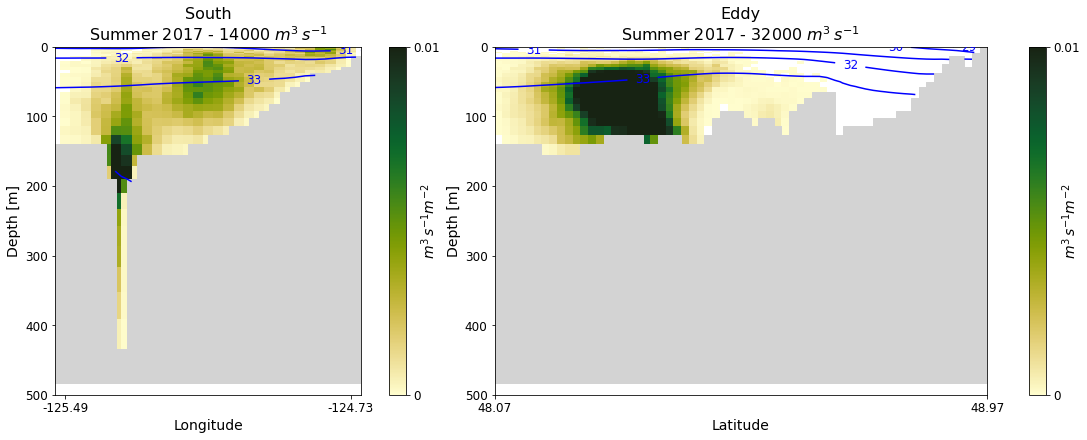

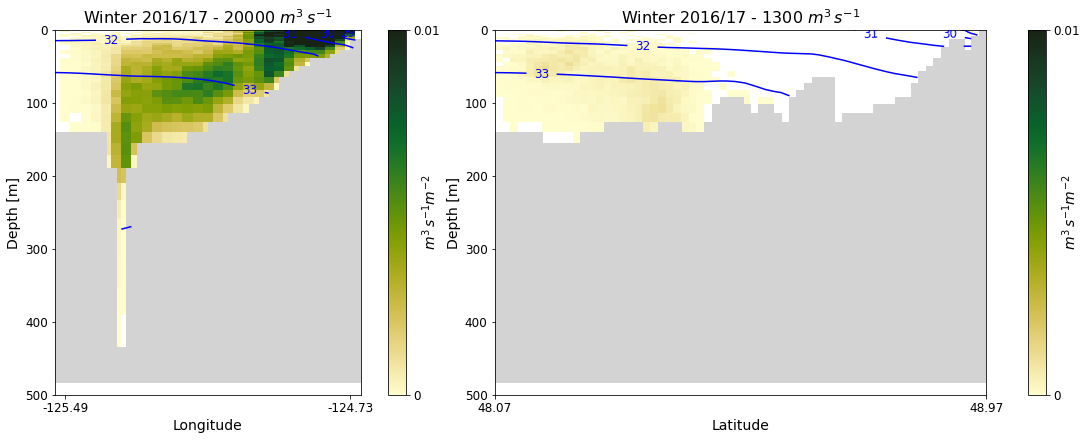

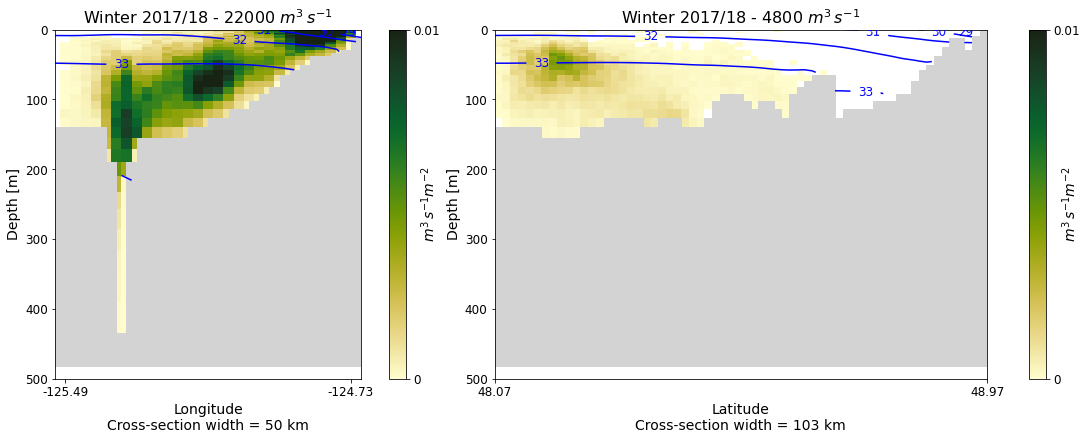

In [56]:
# one presentable figure with all the offshore stuff for the three seasons togetha
plt.rcParams['font.size'] = 12

distlabel = False
fig = plt.figure(constrained_layout=True, figsize=[15,6])
gs = GridSpec(1, 167, figure=fig)
ax1 = fig.add_subplot(gs[0, :64])
ax2 = fig.add_subplot(gs[0, 64:])
f_dist = FluxEW(Sdata, salfileS17, [Canyon[0],South[0]], Canyon[1], South[2], Canyon[3], Canyon[4], distlabel, ax1, 'South\nSummer 2017')
ax1.plot([f_dist[608],f_dist[608]], [0,500], 'k--', zorder=2)
FluxNS(Sdata, salfileS17,  Eddy[0], Eddy[1], Eddy[2], Eddy[3], Eddy[4], distlabel, ax2, 'Eddy\nSummer 2017')
plt.savefig("./figures/EddyFluxS17.png")

fig = plt.figure(constrained_layout=True, figsize=[15,6])
gs = GridSpec(1, 167, figure=fig)
ax1 = fig.add_subplot(gs[0, :64])
ax2 = fig.add_subplot(gs[0, 64:])
f_dist = FluxEW(Wdata16, salfileW16,[Canyon[0],South[0]], Canyon[1], South[2], Canyon[3], Canyon[4], distlabel, ax1, 'Winter 2016/17')
ax1.plot([f_dist[608],f_dist[608]], [0,500], 'k--', zorder=2)
FluxNS(Wdata16, salfileW16, Eddy[0], Eddy[1], Eddy[2], Eddy[3], Eddy[4], distlabel, ax2, 'Winter 2016/17')
# plt.tight_layout()
plt.savefig("./figures/EddyFluxW16.png")

distlabel= True
fig = plt.figure(constrained_layout=True, figsize=[15,6])
gs = GridSpec(1, 167, figure=fig)
ax1 = fig.add_subplot(gs[0, :64])
ax2 = fig.add_subplot(gs[0, 64:])
f_dist = FluxEW(Wdata17, salfileW17,[Canyon[0],South[0]], Canyon[1], South[2], Canyon[3], Canyon[4], distlabel, ax1, 'Winter 2017/18')
ax1.plot([f_dist[608],f_dist[608]], [0,500], 'k--', zorder=2)
FluxNS(Wdata17, salfileW17, Eddy[0], Eddy[1], Eddy[2], Eddy[3], Eddy[4], distlabel, ax2, 'Winter 2017/18')
# plt.tight_layout()
plt.savefig("./figures/EddyFluxW17.png")

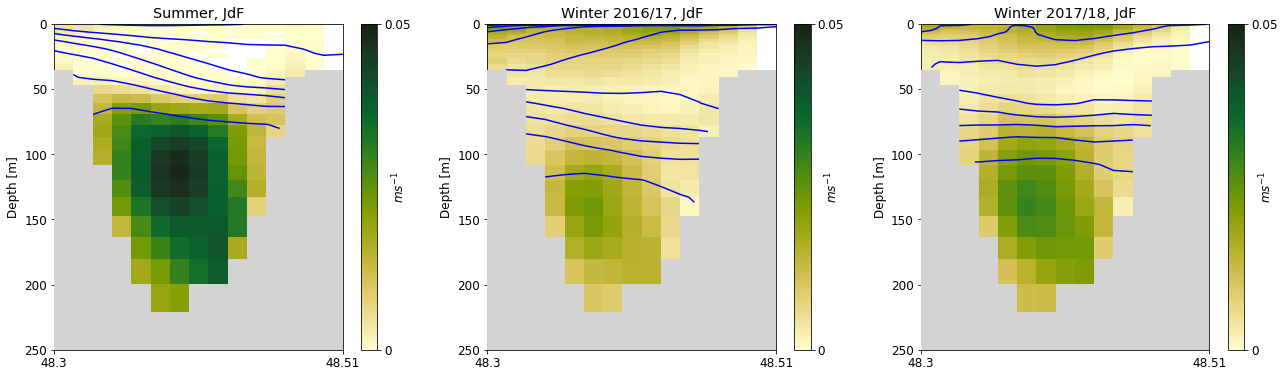

In [37]:
fig, ax = plt.subplots(1,3, figsize=[22,6])
JRFluxNS(Sdata, salfileS17, 'trans', init[1], init[2], init[3], init[4], ax[0], 'Summer, JdF')
JRFluxNS(Wdata16, salfileW16, 'trans', init[1], init[2], init[3], init[4], ax[1], 'Winter 2016/17, JdF')
JRFluxNS(Wdata17, salfileW17, 'trans', init[1], init[2], init[3], init[4], ax[2], 'Winter 2017/18, JdF')

# WM Flow

In [10]:
def FluxSpecificEW(lonW, lonE, figrid, maxdepth, ax, lons, trans, depth, high):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid, :]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[lonW-1:lonE+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lons/m2lon
        
    H1, _, _ = np.histogram2d(dist, depth, bins=[np.array(t_dist[lonW-1:lonE+1]), t_depths],weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    # cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW], t_dist[lonE], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW], t_lons[lonE], 5),2))
    ax.set_xlim((t_dist[lonW], t_dist[lonE-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

In [11]:
def FluxSpecificNS(latS, latN, fjgrid, maxdepth, ax, lats, trans, depth, high):
    jgrid = fjgrid-1
    fmask = mymesh.fmask[0, :, : ,jgrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[jgrid]
    time = mydata.init_t[-1]
    
    t_lats = mymesh.gphit[0, :, jgrid]
    m2lat = ((t_lats[latN]-t_lats[latS])/(mymesh.e2t[0, latS:latN, jgrid].sum()))
    t_dist = t_lats/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    bins = [np.array(t_dist[latS-1:latN+1]), t_depths]
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    t_max = (high/np.sum(trans)).values

    dist = lats/m2lat
        
    H1, _, _ = np.histogram2d(dist, depth, bins=bins,weights= trans, density= True)
    _, xedges, yedges = np.histogram2d(dist, depth, bins = bins)
            
    H_final = H1.T
    H_final = np.where(H_final>0, H_final, H_final*np.nan)

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.speed
    cmap.set_bad('white')
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    tick = np.round(((t_max*np.sum(trans)).values),2)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick]) 
    # cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS], t_dist[latN], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lats[latS], t_lats[latN], 5),2))
    ax.set_xlim((t_dist[latS], t_dist[latN-1]))
    ax.set_ylim((maxdepth, 0))
    # ax.set_title(str(title))
    ax.set_ylabel('Depth [m]')
    mydata.close()

### shallow - salty salty

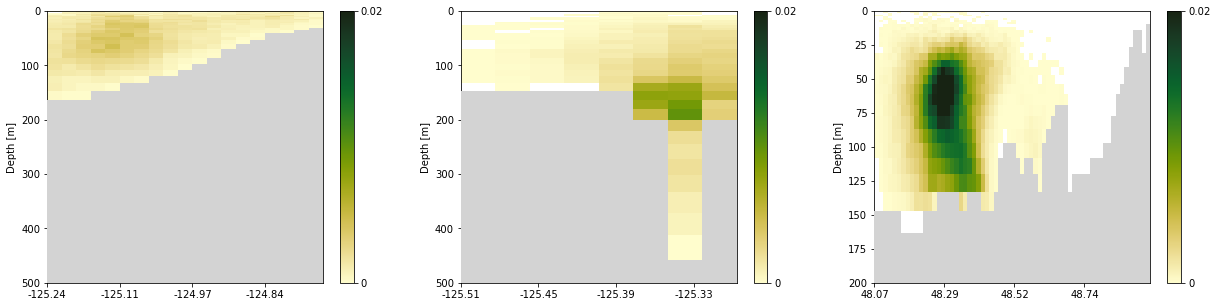

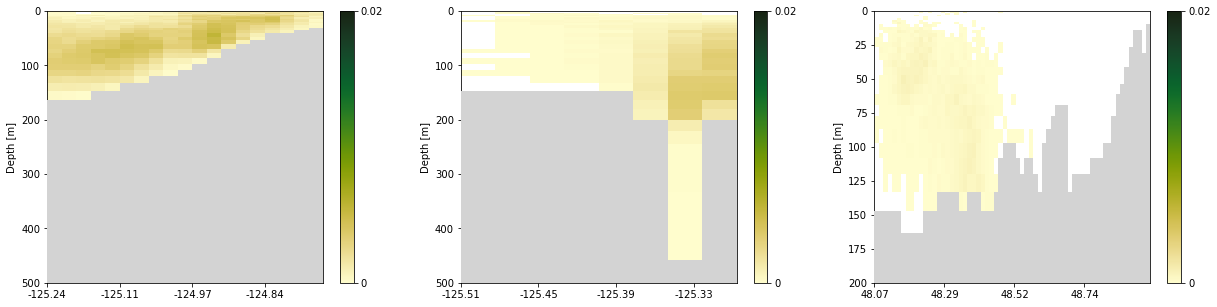

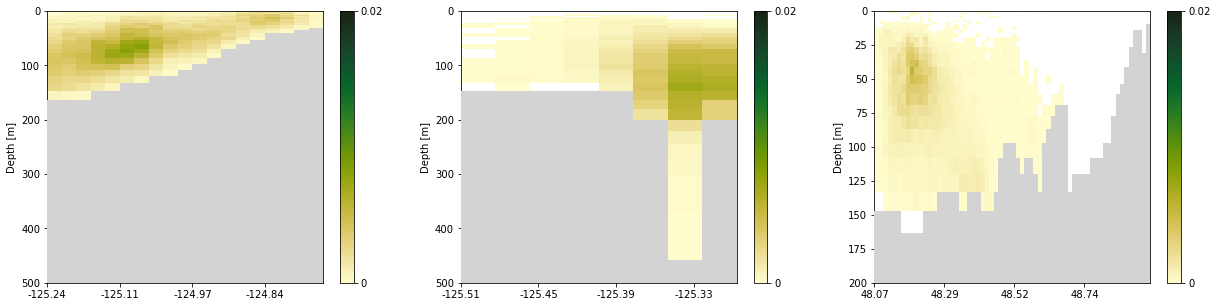

In [8]:
#summer 2017
high = 0.02
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]/time
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]/time
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]/time
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]/time
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]/time
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]/time
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 2)]/time
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section==4)]/time
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth >= -200) & (mydata.final_section == 3)]/time
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

### deep - salty salty

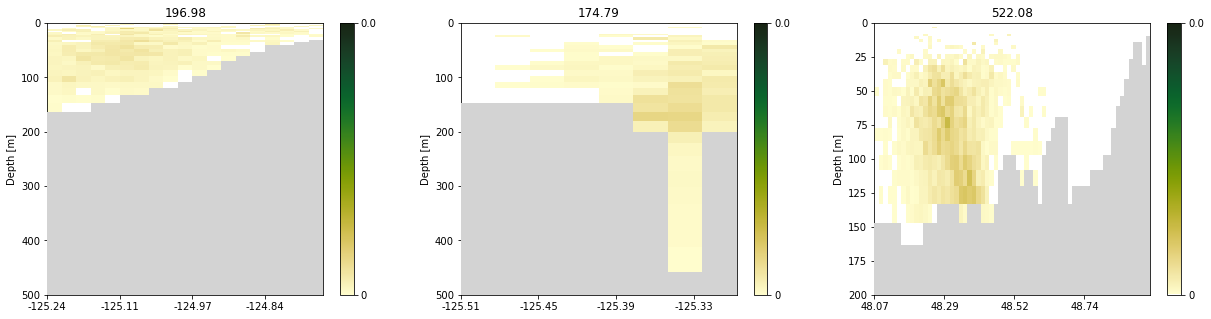

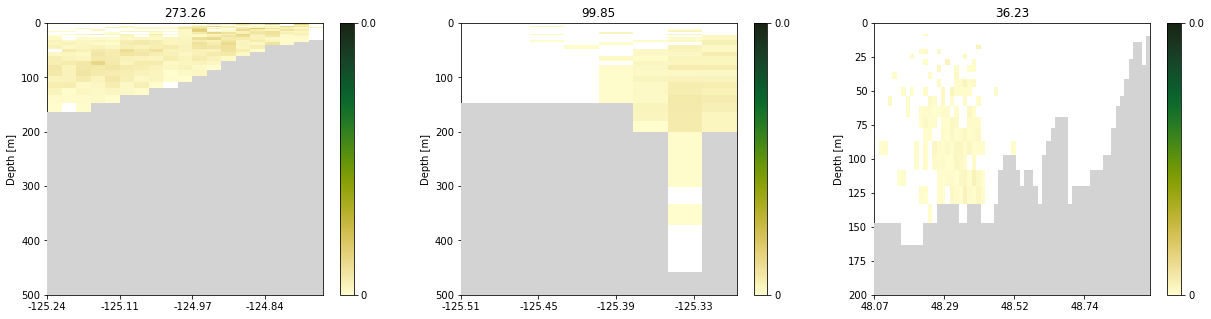

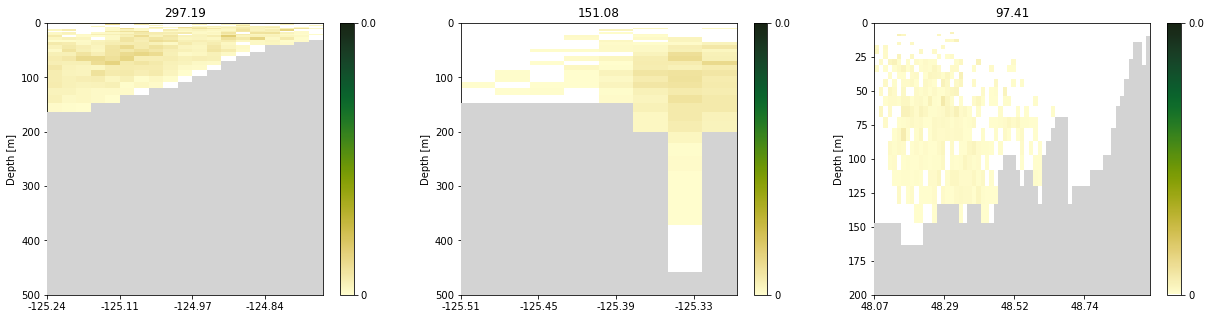

In [47]:
#summer 2017
high = 0.002
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)


#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt > 32.4) & (mydata.init_depth <= -200) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

just a coincedence that the percentage of CUC and the percentage through JdF eddy were the same!

### fresh

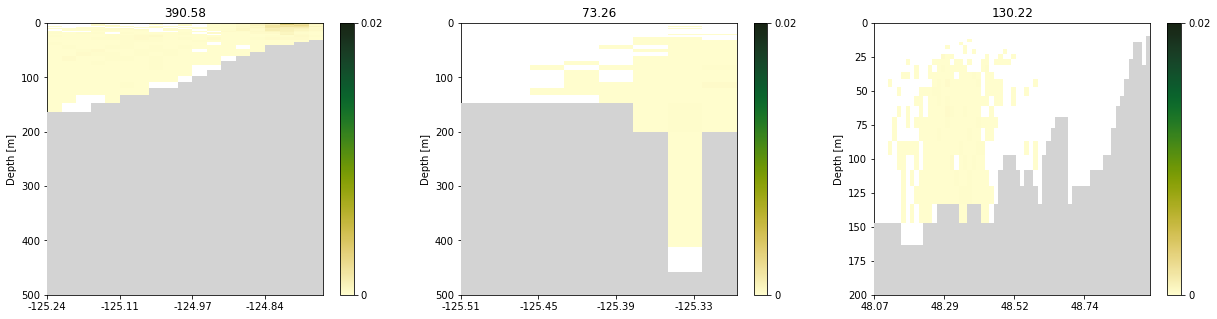

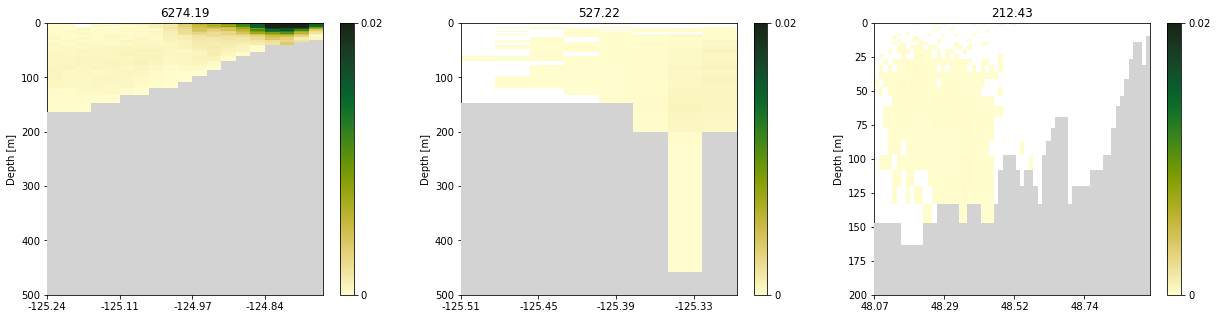

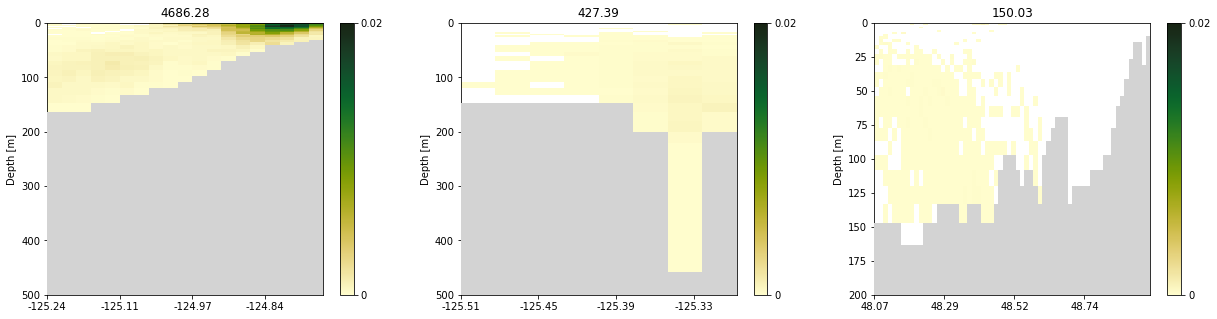

In [48]:
#summer 2017
high = 0.02
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_30sep17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt < 32.4) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

#winter 2016/17
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar17/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)

#winter 2017/18
fig, ax = plt.subplots(1,3,figsize=(21,5))

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_eddybdy_31mar18/ariane_positions_quantitative.nc')
time = mydata.init_t[-1]

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 2)]/time
title = str(np.round(np.sum(trans),2).values)
ax[0].set_title(title)
FluxSpecificEW(South[1], South[2], South[3], South[4], ax[0], lons, trans, depth, high)

lons = mydata.final_lon[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section==4)]/time
title = str(np.round(np.sum(trans),2).values)
ax[1].set_title(title)
FluxSpecificEW(Canyon[1], Canyon[2], Canyon[3], Canyon[4], ax[1], lons, trans, depth, high)

lats = mydata.final_lat[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]
depth = depthf(mydata.final_z[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]-1.)[0]
trans = mydata.final_transp[(mydata.init_salt <= 32.4) & (mydata.final_section == 3)]/time
title = str(np.round(np.sum(trans),2).values)
ax[2].set_title(title)
FluxSpecificNS(Eddy[1], Eddy[2], Eddy[3], Eddy[4], ax[2], lats, trans, depth, high)